In [1]:
import numpy as np
import scipy as sc
import os
import math
import cv2
import matplotlib.pyplot as plt
import dlib
from numpy.linalg import svd, inv
from scipy.spatial import ConvexHull

np.set_printoptions(suppress=True)
%matplotlib inline
import pandas as pd
np.set_printoptions(suppress=True)
%matplotlib inline
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

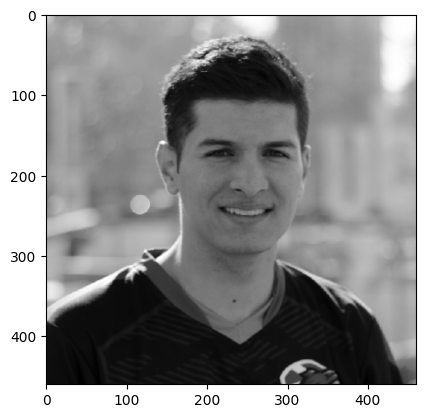

In [ ]:
img1_f = 'sources/raoul.png'
img1 = cv2.cvtColor(cv2.cvtColor(cv2.imread(img1_f), cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img1, cmap='gray')

Found 1 Faces!


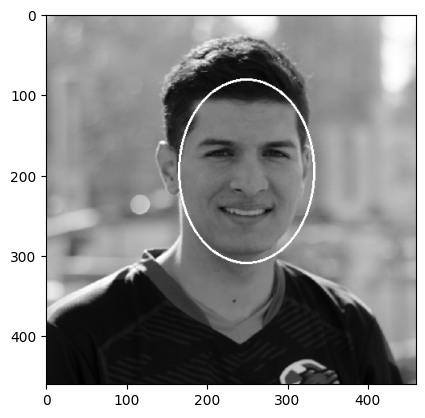

In [ ]:
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
# https://github.com/opencv/opencv/tree/3.4/data/haarcascades
# I think we might need to add 2 more classifiers? one for the smile and the other for the eyes
# this way we can use these 3 classifiers to detect emotions? but I don't know for sure yet as we need
# to know how our data will be on the models we are downloading?
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(
        img1,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

print("Found {0} Faces!".format(len(faces)))

for (x, y, w, h) in faces:
    # cv2.rectangle(img1, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.ellipse(img1, (x + w//2, y + h//2), (w//2-10, h//2+20), 0, 0, 360, (255, 0, 0), 2)
    roi_img = cv2.cvtColor(cv2.imread(img1_f), cv2.COLOR_BGR2RGB)[y:y+h, x:x+w]


plt.figure()
plt.imshow(img1, cmap='gray')

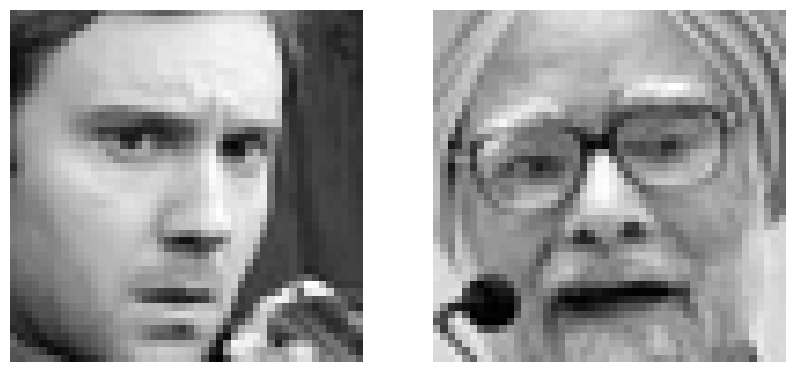

In [18]:
# Load the FER dataset
fer_data = pd.read_csv('sources/fer2013.csv')


num_images = 2
image_pixels = fer_data.head(num_images)['pixels'].values

# Reshape the pixel values into images
images = []
for pixels in image_pixels:
    image = np.array(pixels.split(), dtype='uint8')
    image = image.reshape((48, 48))
    images.append(image)

# Display the images
fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

for ax, image in zip(axes, images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()


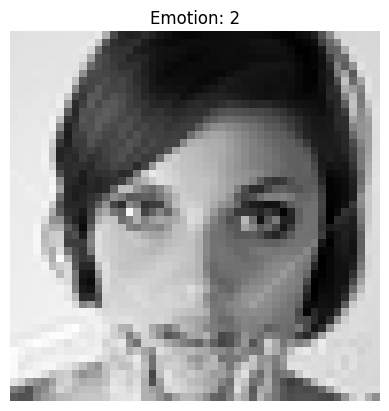

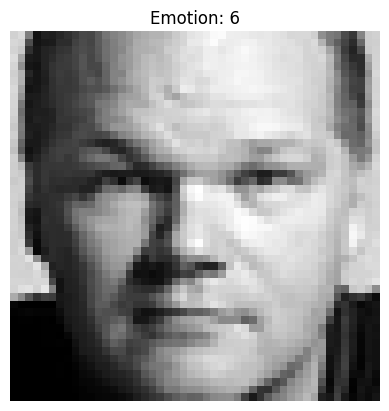

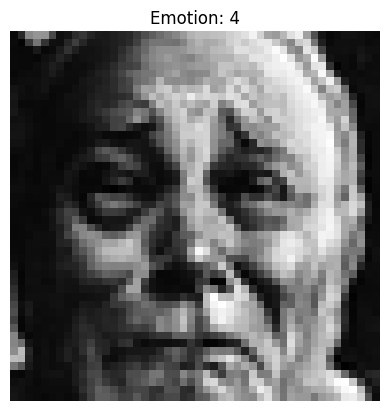

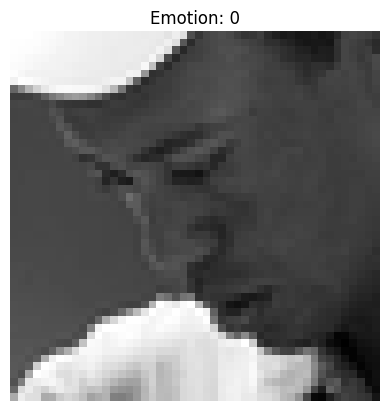

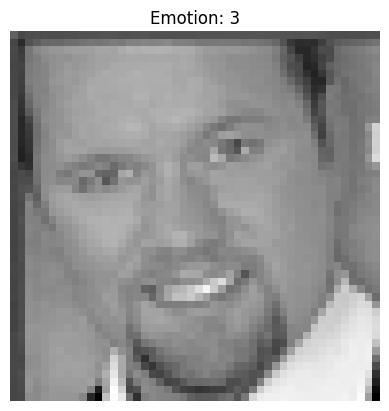

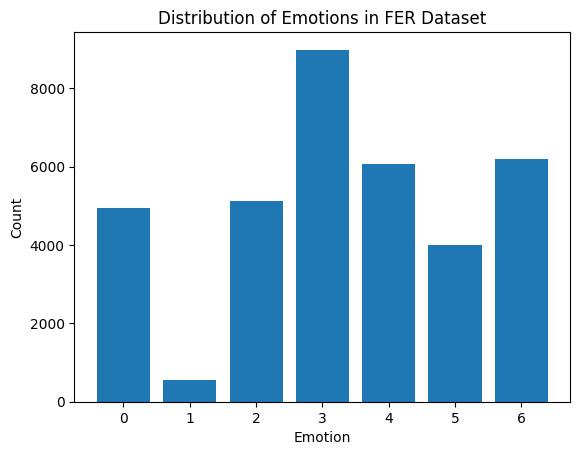

In [19]:

# Display sample images with corresponding labels
sample_indices = np.random.choice(fer_data.index, size=5, replace=False)
for index in sample_indices:
    pixels = fer_data.loc[index, 'pixels']
    emotion = fer_data.loc[index, 'emotion']

    # Convert pixel string to numpy array
    image = np.fromstring(pixels, dtype=int, sep=' ').reshape((48, 48))

    # Display image with emotion label
    plt.imshow(image, cmap='gray')
    plt.title(f'Emotion: {emotion}')
    plt.axis('off')
    plt.show()

# Plot emotion distribution
emotion_counts = fer_data['emotion'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in FER Dataset')
plt.show()

In [20]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in fer_data.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) #reshape for fitting
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)


In [5]:
X_train = np.array(X_train)
print(X_train.shape)
augment = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(rescale=1./255)
augment.fit(X_train)

(28709, 48, 48, 1)


In [21]:
batch_size = 96
train_flow = augment.flow(X_train, y_train, batch_size=batch_size)
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)
#set batch size

In [7]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input, Dense, Flatten, Dropout, BatchNormalization
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1, l2
import tensorflow as tf

In [10]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    #print(model.summary())

    return model

In [9]:
def FER_ModelReg(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    # Regularization parameter
    l2_lambda = 0.001
    #changed from 0.0001
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name='pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name='drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv2_3')(conv2_2)
    conv2_3 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name='pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name='drop2_1')(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name='pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name='drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name='pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name='drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=l2(l2_lambda), name='conv5_4')(conv5_3)
    conv5_4 = BatchNormalization()(conv5_4)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name='pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name='drop5_1')(pool5_1)

    # Flatten and output
    flatten = Flatten(name='flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name='output')(flatten)

    # create model
    model = Model(inputs=visible, outputs=ouput)

    return model

In [11]:
from tensorflow.keras.models import Sequential

def FER_Seq(input_shape=(48,48,1)):
    model = Sequential([
        # 1st block
        Conv2D(64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 2nd block
        Conv2D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(128, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 3rd block
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 4th block
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(256, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # 5th block
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(512, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(7, activation='softmax')
    ])

    return model

In [9]:
model = FER_Model()
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [39]:
model2 = FER_ModelReg()
model2.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
#ended up being the best model

In [46]:
model3 = FER_Seq()
model3.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

model = FER_Model()
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [25]:
num_epochs = 25
#already trained it 75 times, checking 100
history = model.fit(train_flow,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks= [reduce_lr],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/25
299/299 [==============================] - 22s 73ms/step - loss: 0.5785 - accuracy: 0.7825 - val_loss: 1.0008 - val_accuracy: 0.6802 - lr: 3.2000e-08
Epoch 2/25
299/299 [==============================] - 21s 71ms/step - loss: 0.5753 - accuracy: 0.7828 - val_loss: 1.0014 - val_accuracy: 0.6810 - lr: 3.2000e-08
Epoch 3/25
299/299 [==============================] - 21s 72ms/step - loss: 0.5756 - accuracy: 0.7825 - val_loss: 1.0024 - val_accuracy: 0.6805 - lr: 3.2000e-08
Epoch 4/25
299/299 [==============================] - 22s 72ms/step - loss: 0.5755 - accuracy: 0.7850 - val_loss: 1.0017 - val_accuracy: 0.6796 - lr: 3.2000e-08
Epoch 5/25
299/299 [==============================] - 22s 74ms/step - loss: 0.5784 - accuracy: 0.7845 - val_loss: 1.0034 - val_accuracy: 0.6822 - lr: 3.2000e-08
Epoch 6/25
299/299 [==============================] - 22s 74ms/step - loss: 0.5792 - accuracy: 0.7827 - val_loss: 0.9988 - val_accuracy: 0.6822 - lr: 3.2000e-08
Epoch 7/25
299/299 [==============

In [ ]:
num_epochs = 75

history = model.fit(X_train, y_train,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/75
299/299 [==============================] - 63s 136ms/step - loss: 2.0904 - accuracy: 0.2108 - val_loss: 1.8584 - val_accuracy: 0.2503
Epoch 2/75
299/299 [==============================] - 37s 124ms/step - loss: 1.8024 - accuracy: 0.2559 - val_loss: 1.9592 - val_accuracy: 0.1703
Epoch 3/75
299/299 [==============================] - 38s 129ms/step - loss: 1.7370 - accuracy: 0.2959 - val_loss: 1.9819 - val_accuracy: 0.1698
Epoch 4/75
299/299 [==============================] - 38s 127ms/step - loss: 1.6555 - accuracy: 0.3456 - val_loss: 1.9573 - val_accuracy: 0.1827
Epoch 5/75
299/299 [==============================] - 38s 126ms/step - loss: 1.5668 - accuracy: 0.3847 - val_loss: 1.9419 - val_accuracy: 0.1819
Epoch 6/75
299/299 [==============================] - 38s 127ms/step - loss: 1.5033 - accuracy: 0.4107 - val_loss: 1.9145 - val_accuracy: 0.1813
Epoch 7/75
299/299 [==============================] - 38s 126ms/step - loss: 1.4365 - accuracy: 0.4413 - val_loss: 2.0205 - val_ac

299/299 [==============================] - 10s 33ms/step - loss: 0.0824 - accuracy: 0.9721 - val_loss: 2.3767 - val_accuracy: 0.1301


In [31]:
num_epochs = 100
#reg model
#attempted with Lr = 0.0001, kernel reg at 0.0001
history2 = model2.fit(train_flow,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks= [reduce_lr],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/100
299/299 [==============================] - 25s 76ms/step - loss: 2.8694 - accuracy: 0.2111 - val_loss: 2.3075 - val_accuracy: 0.2477 - lr: 1.0000e-04
Epoch 2/100
299/299 [==============================] - 22s 73ms/step - loss: 2.3371 - accuracy: 0.2387 - val_loss: 2.3786 - val_accuracy: 0.2489 - lr: 1.0000e-04
Epoch 3/100
299/299 [==============================] - 22s 74ms/step - loss: 2.2381 - accuracy: 0.2557 - val_loss: 2.2400 - val_accuracy: 0.2677 - lr: 1.0000e-04
Epoch 4/100
299/299 [==============================] - 22s 74ms/step - loss: 2.2065 - accuracy: 0.2684 - val_loss: 2.3066 - val_accuracy: 0.2756 - lr: 1.0000e-04
Epoch 5/100
299/299 [==============================] - 23s 76ms/step - loss: 2.1666 - accuracy: 0.2876 - val_loss: 2.2008 - val_accuracy: 0.3024 - lr: 1.0000e-04
Epoch 6/100
299/299 [==============================] - 23s 77ms/step - loss: 2.1320 - accuracy: 0.3145 - val_loss: 2.2799 - val_accuracy: 0.3015 - lr: 1.0000e-04
Epoch 7/100
299/299 [=======

In [40]:
num_epochs = 80
#reg model
#attempted with Lr = 0.0001, kernel reg at 0.001
history2 = model2.fit(train_flow,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks= [reduce_lr],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/80
299/299 [==============================] - 25s 79ms/step - loss: 6.7382 - accuracy: 0.2044 - val_loss: 6.1253 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/80
299/299 [==============================] - 23s 78ms/step - loss: 6.1249 - accuracy: 0.2429 - val_loss: 6.0706 - val_accuracy: 0.2492 - lr: 1.0000e-04
Epoch 3/80
299/299 [==============================] - 24s 79ms/step - loss: 5.9955 - accuracy: 0.2560 - val_loss: 5.9373 - val_accuracy: 0.2587 - lr: 1.0000e-04
Epoch 4/80
299/299 [==============================] - 24s 80ms/step - loss: 5.9052 - accuracy: 0.2685 - val_loss: 5.8846 - val_accuracy: 0.2711 - lr: 1.0000e-04
Epoch 5/80
299/299 [==============================] - 24s 80ms/step - loss: 5.8161 - accuracy: 0.2824 - val_loss: 5.7900 - val_accuracy: 0.2934 - lr: 1.0000e-04
Epoch 6/80
299/299 [==============================] - 24s 80ms/step - loss: 5.7150 - accuracy: 0.3022 - val_loss: 5.6514 - val_accuracy: 0.3274 - lr: 1.0000e-04
Epoch 7/80
299/299 [==============

In [47]:
num_epochs = 80
#sequential model. Essentially the same
history3 = model3.fit(train_flow,
                    steps_per_epoch= int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks= [reduce_lr],
                    validation_steps= int(len(X_test) / batch_size))

Epoch 1/80
299/299 [==============================] - 26s 80ms/step - loss: 6.6691 - accuracy: 0.2073 - val_loss: 6.0754 - val_accuracy: 0.2489 - lr: 1.0000e-04
Epoch 2/80
299/299 [==============================] - 22s 75ms/step - loss: 6.1093 - accuracy: 0.2478 - val_loss: 6.0328 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 3/80
299/299 [==============================] - 22s 75ms/step - loss: 5.9810 - accuracy: 0.2599 - val_loss: 5.9370 - val_accuracy: 0.2613 - lr: 1.0000e-04
Epoch 4/80
299/299 [==============================] - 23s 76ms/step - loss: 5.8704 - accuracy: 0.2818 - val_loss: 5.8087 - val_accuracy: 0.2959 - lr: 1.0000e-04
Epoch 5/80
299/299 [==============================] - 23s 77ms/step - loss: 5.7672 - accuracy: 0.2969 - val_loss: 5.7355 - val_accuracy: 0.3215 - lr: 1.0000e-04
Epoch 6/80
299/299 [==============================] - 23s 78ms/step - loss: 5.6314 - accuracy: 0.3282 - val_loss: 5.5770 - val_accuracy: 0.3654 - lr: 1.0000e-04
Epoch 7/80
299/299 [==============

In [ ]:
model_json = model2.to_json()
with open("seq.json", "w") as json_file:
    json_file.write(model_json)
model2.save_weights("seq.h5")

print("model saved")

In [43]:
#save in newer keras format
model2.save("seq.keras")

In [35]:
print(tf.__version__)
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
TensorFlow version: 2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
# new_model = tf.keras.models.load_model('model.keras')
model.load_weights('sources/model.h5')

In [45]:
# model.summary()

In [22]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(X_test).shape)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.6381 - loss: 2.4114
Restored model, accuracy: 63.75%
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step
(3589, 7)


## Test Runs of Models

In [33]:
# def ThreeBlockFER(input_shape=(48,48,1)):
#     visible = Input(shape=input_shape, name='input')
#     num_classes = 7

#     # First Convolutional Block
#     conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv1_1')(visible)
#     conv1_1 = BatchNormalization()(conv1_1)
#     conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv1_2')(conv1_1)
#     conv1_2 = BatchNormalization()(conv1_2)
#     pool1_1 = MaxPooling2D(pool_size=(2,2), name='pool1_1')(conv1_2)
#     drop1_1 = Dropout(0.3, name='drop1_1')(pool1_1)

#     # Second Convolutional Block
#     conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv2_1')(drop1_1)
#     conv2_1 = BatchNormalization()(conv2_1)
#     conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv2_2')(conv2_1)
#     conv2_2 = BatchNormalization()(conv2_2)
#     pool2_1 = MaxPooling2D(pool_size=(2,2), name='pool2_1')(conv2_2)
#     drop2_1 = Dropout(0.3, name='drop2_1')(pool2_1)

#     # Third Convolutional Block
#     conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv3_1')(drop2_1)
#     conv3_1 = BatchNormalization()(conv3_1)
#     conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01), name='conv3_2')(conv3_1)
#     conv3_2 = BatchNormalization()(conv3_2)
#     pool3_1 = MaxPooling2D(pool_size=(2,2), name='pool3_1')(conv3_2)
#     drop3_1 = Dropout(0.3, name='drop3_1')(pool3_1)

#     # Flatten and Output Layer
#     flatten = Flatten(name='flatten')(drop3_1)
#     output = Dense(num_classes, activation='softmax', name='output')(flatten)

#     # Create Model
#     model = Model(inputs=visible, outputs=output)

#     return model


# model2 = FER_Model3()
# model2.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [34]:
# model2.load_weights('sources/model2.h5')
# model2.summary()

In [31]:

# def ThreeBlockFER2(input_shape=(48,48,1)):
#     visible = Input(shape=input_shape, name='input')
#     num_classes = 7

#     # First Convolutional Block
#     conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_1')(visible)
#     conv1_1 = BatchNormalization()(conv1_1)
#     conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_2')(conv1_1)
#     conv1_2 = BatchNormalization()(conv1_2)
#     pool1_1 = MaxPooling2D(pool_size=(2,2), name='pool1_1')(conv1_2)
#     drop1_1 = Dropout(0.3, name='drop1_1')(pool1_1)

#     # Second Convolutional Block
#     conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_1')(drop1_1)
#     conv2_1 = BatchNormalization()(conv2_1)
#     conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_2')(conv2_1)
#     conv2_2 = BatchNormalization()(conv2_2)
#     pool2_1 = MaxPooling2D(pool_size=(2,2), name='pool2_1')(conv2_2)
#     drop2_1 = Dropout(0.3, name='drop2_1')(pool2_1)

#     # Third Convolutional Block
#     conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_1')(drop2_1)
#     conv3_1 = BatchNormalization()(conv3_1)
#     conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_2')(conv3_1)
#     conv3_2 = BatchNormalization()(conv3_2)
#     pool3_1 = MaxPooling2D(pool_size=(2,2), name='pool3_1')(conv3_2)
#     drop3_1 = Dropout(0.3, name='drop3_1')(pool3_1)

#     # Flatten and Output Layer
#     flatten = Flatten(name='flatten')(drop3_1)
#     output = Dense(num_classes, activation='softmax', name='output')(flatten)

#     # Create Model
#     model = Model(inputs=visible, outputs=output)

#     return model

In [52]:
ogmodel = FER_Model()
ogmodel.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
ogmodel.load_weights('sources/model.h5')
ogmodel.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_131         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_132         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1_1 (MaxPooling2D)          │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1_1 (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2_1 (MaxPooling2D)          │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2_1 (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_138         │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_4 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,111,367 (50.02 MB)

 Trainable params: 13,103,431 (49.99 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [34]:
train_loss, train_accu = ogmodel.evaluate(X_train, y_train)
test_loss, test_accu = ogmodel.evaluate(X_test, y_test)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 1s 12ms/step - loss: 19.2155 - accuracy: 0.2048
final train accuracy = 21.28 , validation accuracy = 20.48


In [27]:
# train_loss, train_accu = model.evaluate(X_train, y_train)
# test_loss, test_accu = model.evaluate(X_test, y_test)


train_loss, train_accu = model.evaluate(train_flow)
test_loss, test_accu = model.evaluate(test_flow)
# pred_results = model.evaluate(test_flow)
print(pred_results)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 1s 21ms/step - loss: 0.9997 - accuracy: 0.6824
[0.9996629357337952, 0.6823627948760986]
final train accuracy = 81.74 , validation accuracy = 68.24


In [34]:
#with reg on 100 epo. need to reduce loss
train_loss, train_accu = model2.evaluate(train_flow)
test_loss, test_accu = model2.evaluate(test_flow)
# pred_results = model.evaluate(test_flow)
print(pred_results)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 1s 24ms/step - loss: 1.2613 - accuracy: 0.6704
[0.9996629357337952, 0.6823627948760986]
final train accuracy = 80.50 , validation accuracy = 67.04


In [41]:
#with reg on 100 epo. need to reduce loss
train_loss, train_accu = model2.evaluate(train_flow)
test_loss, test_accu = model2.evaluate(test_flow)
# pred_results = model.evaluate(test_flow)
print(pred_results)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 1s 23ms/step - loss: 1.5386 - accuracy: 0.6840
[0.9996629357337952, 0.6823627948760986]
final train accuracy = 86.75 , validation accuracy = 68.40


In [29]:
#This is the current best model (FerModelReg)
train_loss, train_accu = ogmodel.evaluate(train_flow)
test_loss, test_accu = ogmodel.evaluate(test_flow)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

38/38 [==============================] - 1s 24ms/step - loss: 1.5386 - accuracy: 0.6840
final train accuracy = 86.96 , validation accuracy = 68.40


In [33]:
total_samples = len(test_flow)
print(total_samples)
steps_per_epoch = total_samples // batch_size
if total_samples % batch_size != 0:
    steps_per_epoch += 1  # Include the remaining samples in the last incomplete batch


test_accu = ogmodel.predict(test_flow, steps = 38)
predicted_labels = np.argmax(test_accu, axis=1)

print(predicted_labels)

38
38/38 [==============================] - 1s 22ms/step
[5 1 3 ... 4 4 6]


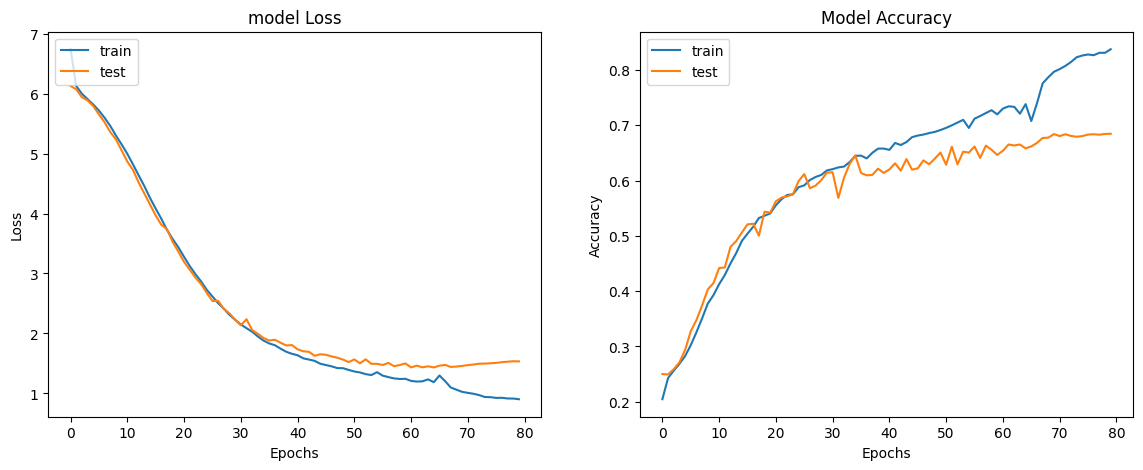

In [44]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
ogmodel = FER_ModelReg()
ogmodel.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
ogmodel.load_weights('86ta68va.h5')
ogmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

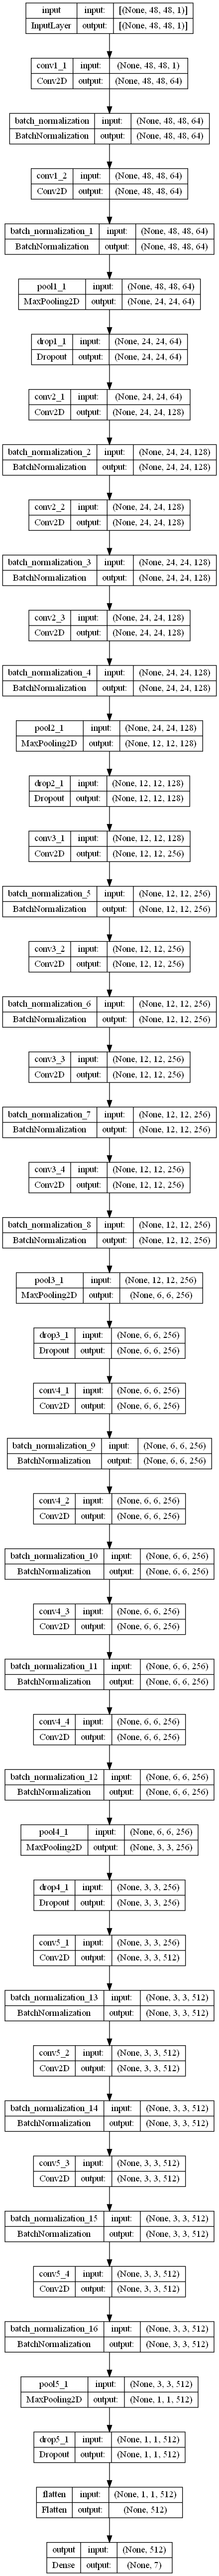

In [15]:
tf.keras.utils.plot_model(ogmodel, to_file='fernet.png', show_shapes=True, show_layer_names=True)
#pip install pydot and conda install graphviz